In [1]:
import data_gen
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [2]:
data = data_gen.generate_and_save()

In [3]:
data = np.load("data.npz")

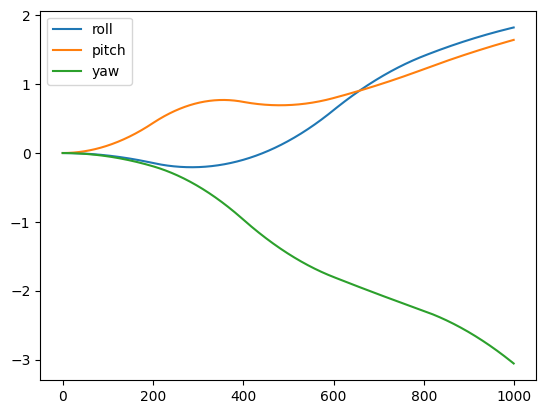

In [4]:
def plot_rpy(rpy: np.ndarray) -> None:
    plt.plot(rpy[:, 0], label="roll")
    plt.plot(rpy[:, 1], label="pitch")
    plt.plot(rpy[:, 2], label="yaw")
    plt.legend()
    plt.show()

rotations = R.from_quat(data["gt_q"][:, :, 0])
plot_rpy(rotations.as_euler("zyx", degrees=True))

In [5]:
from usque import run_ukf, DEFAULT_TYPE
from consts import n, N

# Initialize everything
x0 = np.array([[0, 0, 0, 0.1, 0.1, 0.1]], dtype=DEFAULT_TYPE).T
# P0 = diag([attitude err cov, bias err cov])
P0 = np.eye(n, dtype=DEFAULT_TYPE) * 1e-4  # TODO double check

Y = data["noisy_acc"]  # IMU Accel observations
W = data["noisy_omega"]  # IMU Gyro observations

run_ukf(x0, P0, Y, W)

0
[0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
[[[-5.0227e-03]
  [ 4.7845e-03]
  [ 9.8100e+00]]

 [[-5.0227e-03]
  [-2.5473e-01]
  [ 9.8067e+00]]

 [[ 2.5449e-01]
  [ 4.7845e-03]
  [ 9.8067e+00]]

 [[-5.1475e-03]
  [ 4.6500e-03]
  [ 9.8100e+00]]

 [[-5.0542e-03]
  [ 6.0819e-03]
  [ 9.8100e+00]]

 [[-6.3200e-03]
  [ 4.7530e-03]
  [ 9.8100e+00]]

 [[-5.0224e-03]
  [ 4.7849e-03]
  [ 9.8100e+00]]

 [[-5.0227e-03]
  [ 2.6430e-01]
  [ 9.8064e+00]]

 [[-2.6453e-01]
  [ 4.7845e-03]
  [ 9.8064e+00]]

 [[-4.8943e-03]
  [ 4.9157e-03]
  [ 9.8100e+00]]

 [[-4.9912e-03]
  [ 3.4872e-03]
  [ 9.8100e+00]]

 [[-3.7253e-03]
  [ 4.8160e-03]
  [ 9.8100e+00]]

 [[-5.0230e-03]
  [ 4.7842e-03]
  [ 9.8100e+00]]]
1
[-6.0003e-04 -6.0003e-04  1.0050e-04  9.9501e-05  9.9995e-05  9.9995e-05]


LinAlgError: Matrix is not positive definite